In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import numpy as np

import pandas as pd

import pymc3 as pm

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from modules.stats import GLMMPerformance

In [3]:
def sns_styleset():
    sns.set(context='paper', style='ticks')
    matplotlib.rcParams['figure.dpi']        = 300
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size']  = 3
    matplotlib.rcParams['ytick.major.size']  = 3
    matplotlib.rcParams['xtick.minor.size']  = 2
    matplotlib.rcParams['ytick.minor.size']  = 2
    matplotlib.rcParams['font.size']         = 9
    matplotlib.rcParams['axes.titlesize']    = 9
    matplotlib.rcParams['axes.labelsize']    = 9
    matplotlib.rcParams['legend.fontsize']   = 9
    matplotlib.rcParams['xtick.labelsize']   = 9
    matplotlib.rcParams['ytick.labelsize']   = 9
    
sns_styleset()

In [4]:
TUNERS_REMAP = {
    'rs': 'Random Search',
    'gp': 'Gaussian Process',
    'hb': 'HyperBand'
    
}
SOURCE_REMAP = {
    'mn_v': 'Vanilla \n MNIST',
    'mn_b': 'Back \n MNIST',
    'mn_r': 'Rotated \n MNIST',
    'mn_rb': 'RotBack \n MNIST',
}
METRIC_REMAP = {
    'acc': 'Accuracy',
    'f1': 'F1 Score',
    'precision': 'Precision',
    'recall': 'Recall',
    'time': 'Execution Time',
    'n_conf': 'Explored Configurations'
}

df = pd.read_csv('results\\tables\\models_results.csv')
tuners_df = []
for source in df['source'].unique():
    
    tuners_df.append(
        pd.read_csv(f'results\\tables\\tuners_results_{source}.csv')
    )
tuners_df = pd.concat(tuners_df)
df = df.merge(tuners_df, how='inner', on=['tuner', 'source'])


df['tuner'] = df['tuner'].map(TUNERS_REMAP)
df['source'] = df['source'].map(SOURCE_REMAP)

melted = pd.melt(df, id_vars=['tuner', 'source'], var_name='metric')
melted['metric'] = melted['metric'].map(METRIC_REMAP)
melted=melted.rename(columns={'tuner': 'Tuner', 'source': 'Source'})

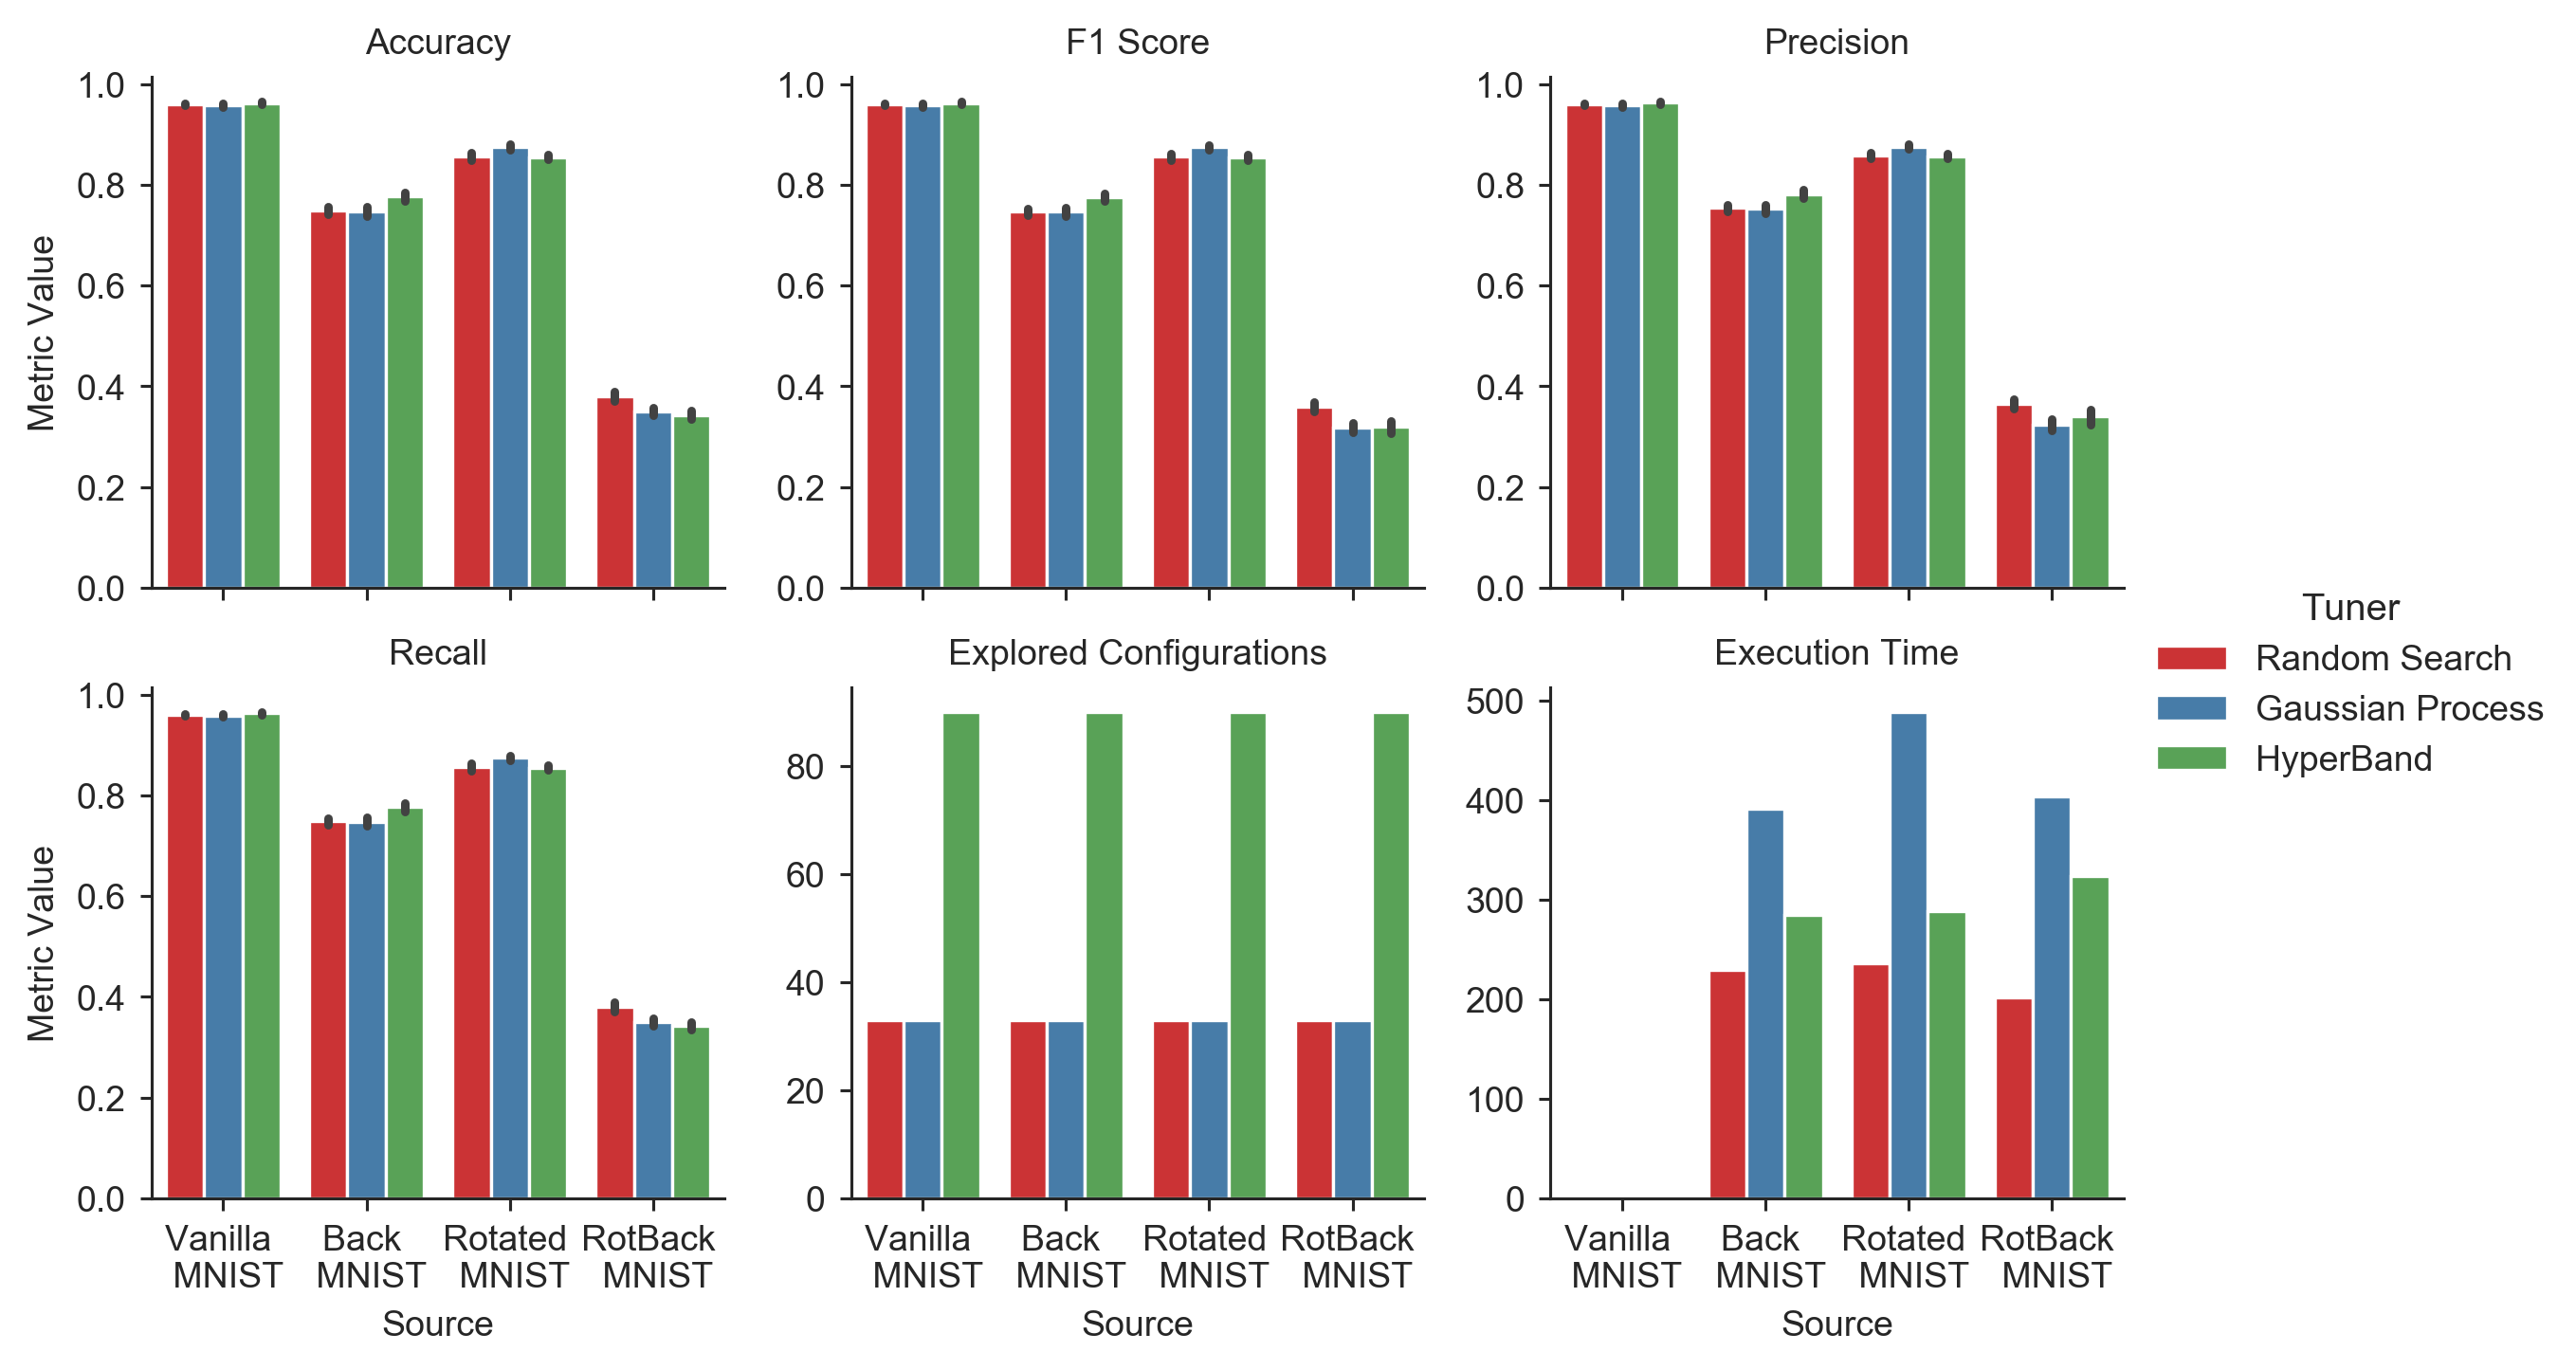

In [5]:
box_plots = sns.catplot(
    x='Source', 
    y='value', 
    col='metric',
    kind='bar',
    data=melted,
    col_wrap=3,
    height=2.5,
    sharey=False,
    sharex=True,
    hue='Tuner',
    palette='Set1'
)
box_plots.set_titles('{col_name}')
box_plots.set_ylabels('Metric Value')
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('results\\figures\\tuners_perfromance.png')
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Tuner, Fixed Intercept, Context, hyper_sigma, hyper_normal]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.
The number of effective samples is smaller than 25% for some parameters.


Accuracy
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
Tuner[0]  0.030  0.028  -0.023    0.081      0.001    0.001     985.0   985.0   
Tuner[1]  0.027  0.027  -0.025    0.078      0.001    0.001     983.0   983.0   
Tuner[2]  0.028  0.028  -0.024    0.079      0.001    0.001     989.0   989.0   

          ess_bulk  ess_tail  r_hat  
Tuner[0]     989.0    1386.0    1.0  
Tuner[1]     986.0    1350.0    1.0  
Tuner[2]     993.0    1306.0    1.0  


C:\Users\penthotal\Desktop\git_repositories\kerastuner_benchmark\modules\stats.py:179: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


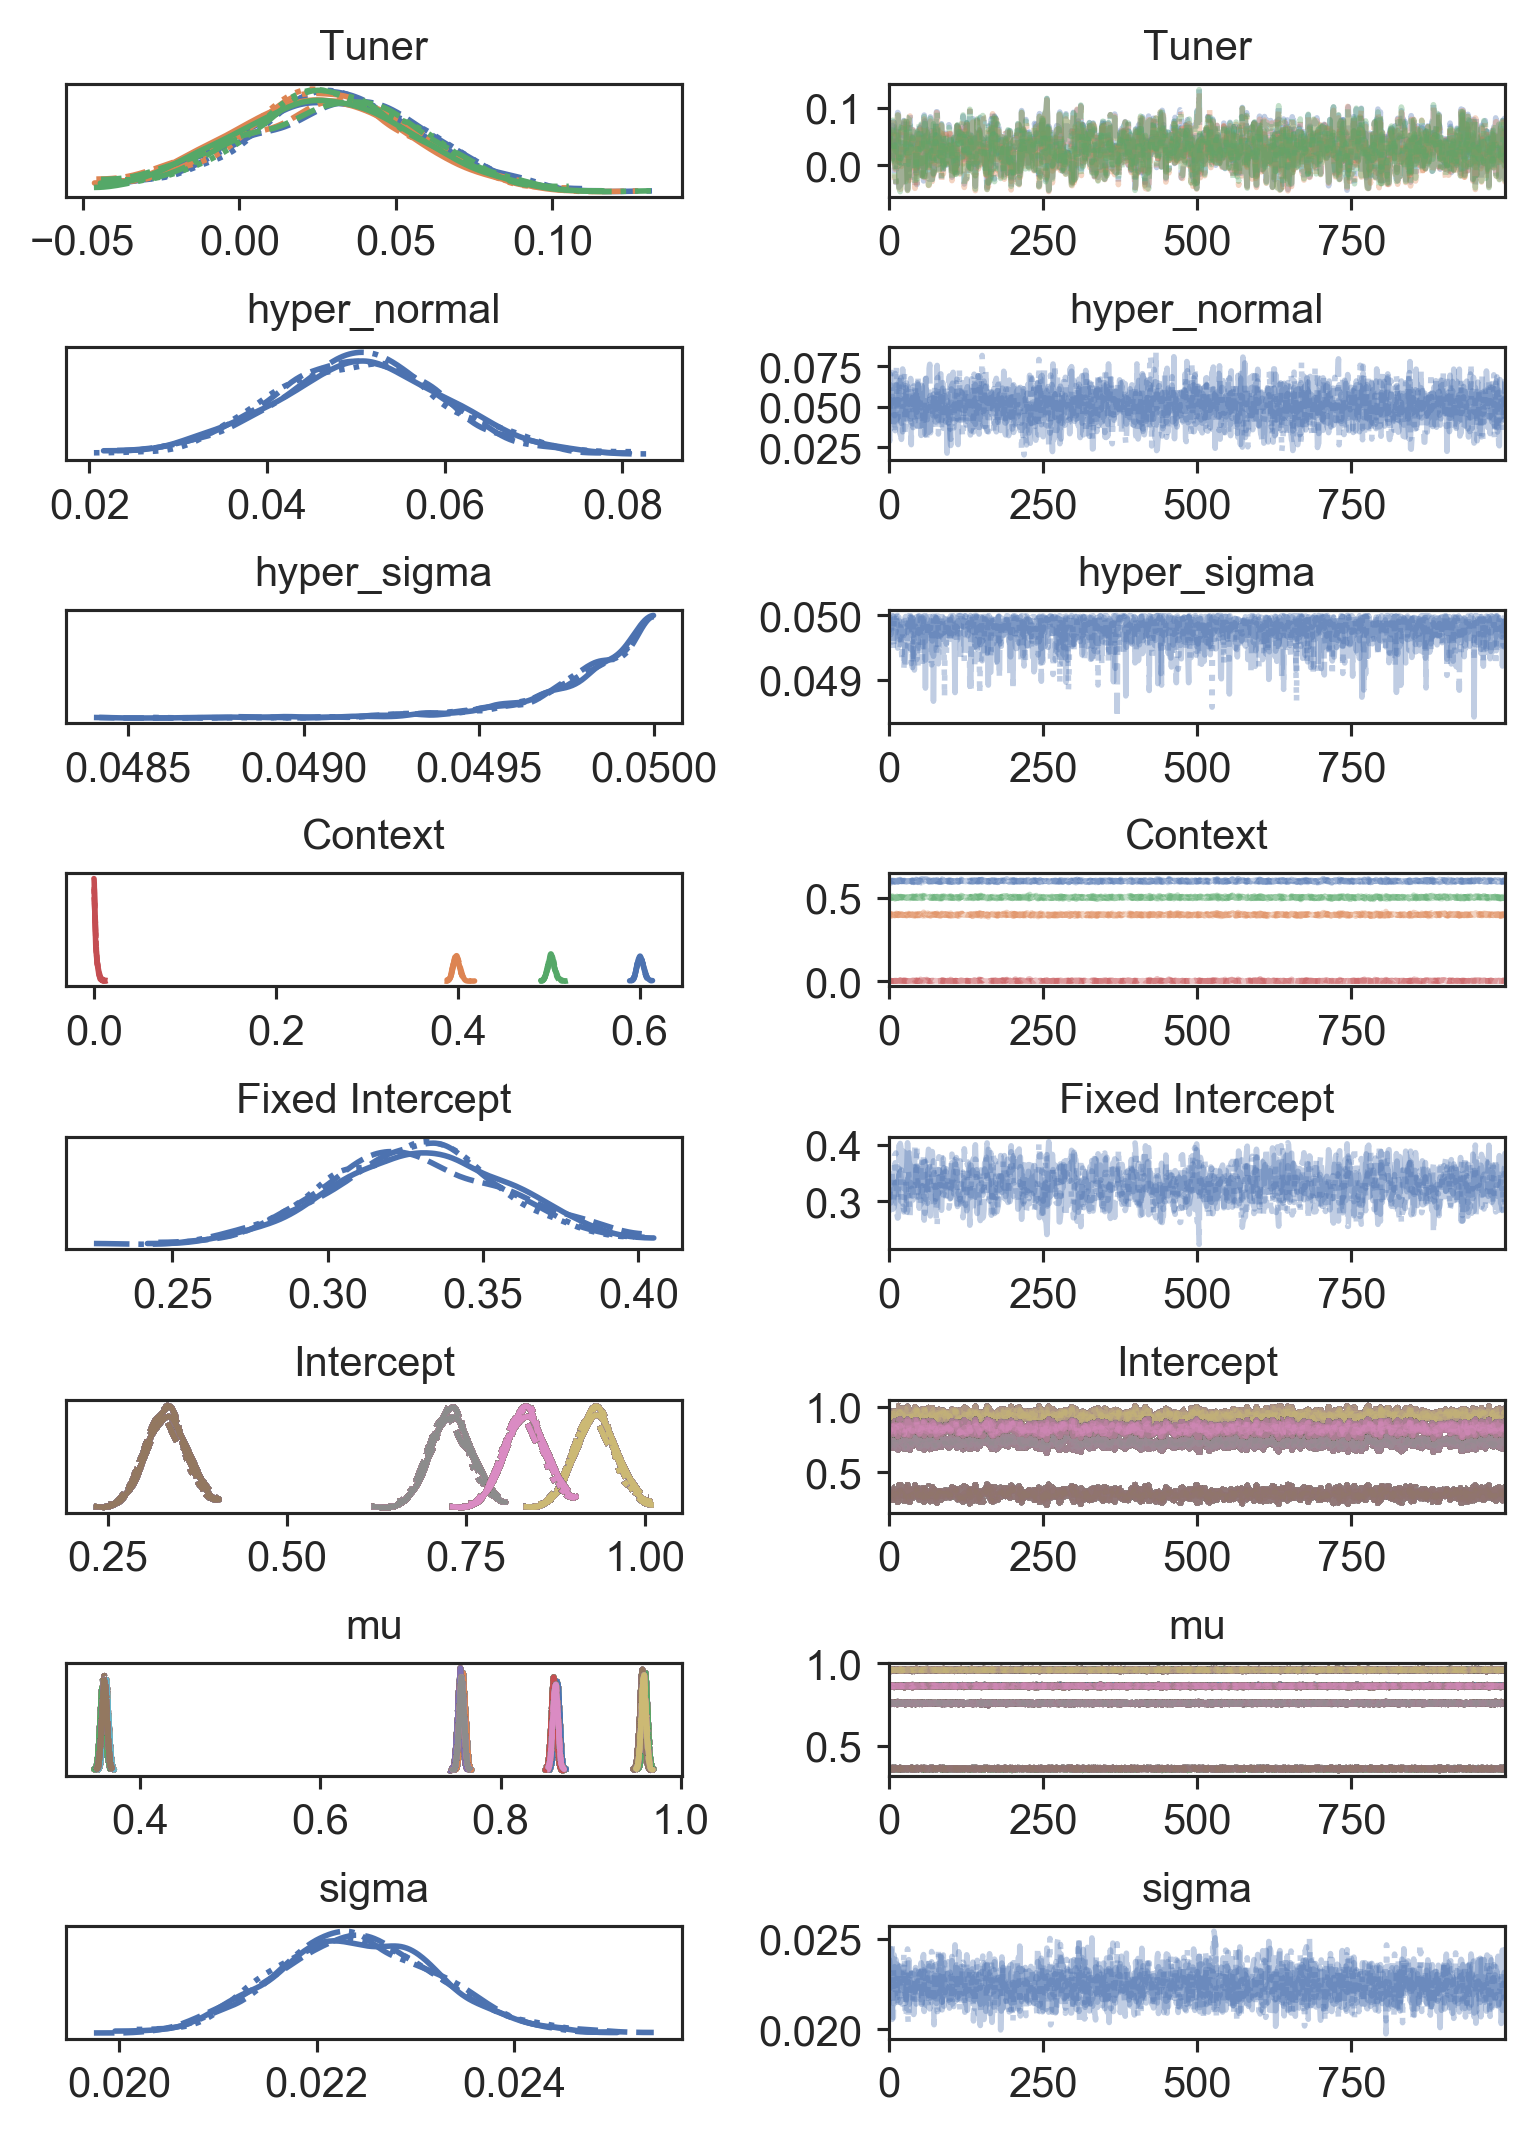

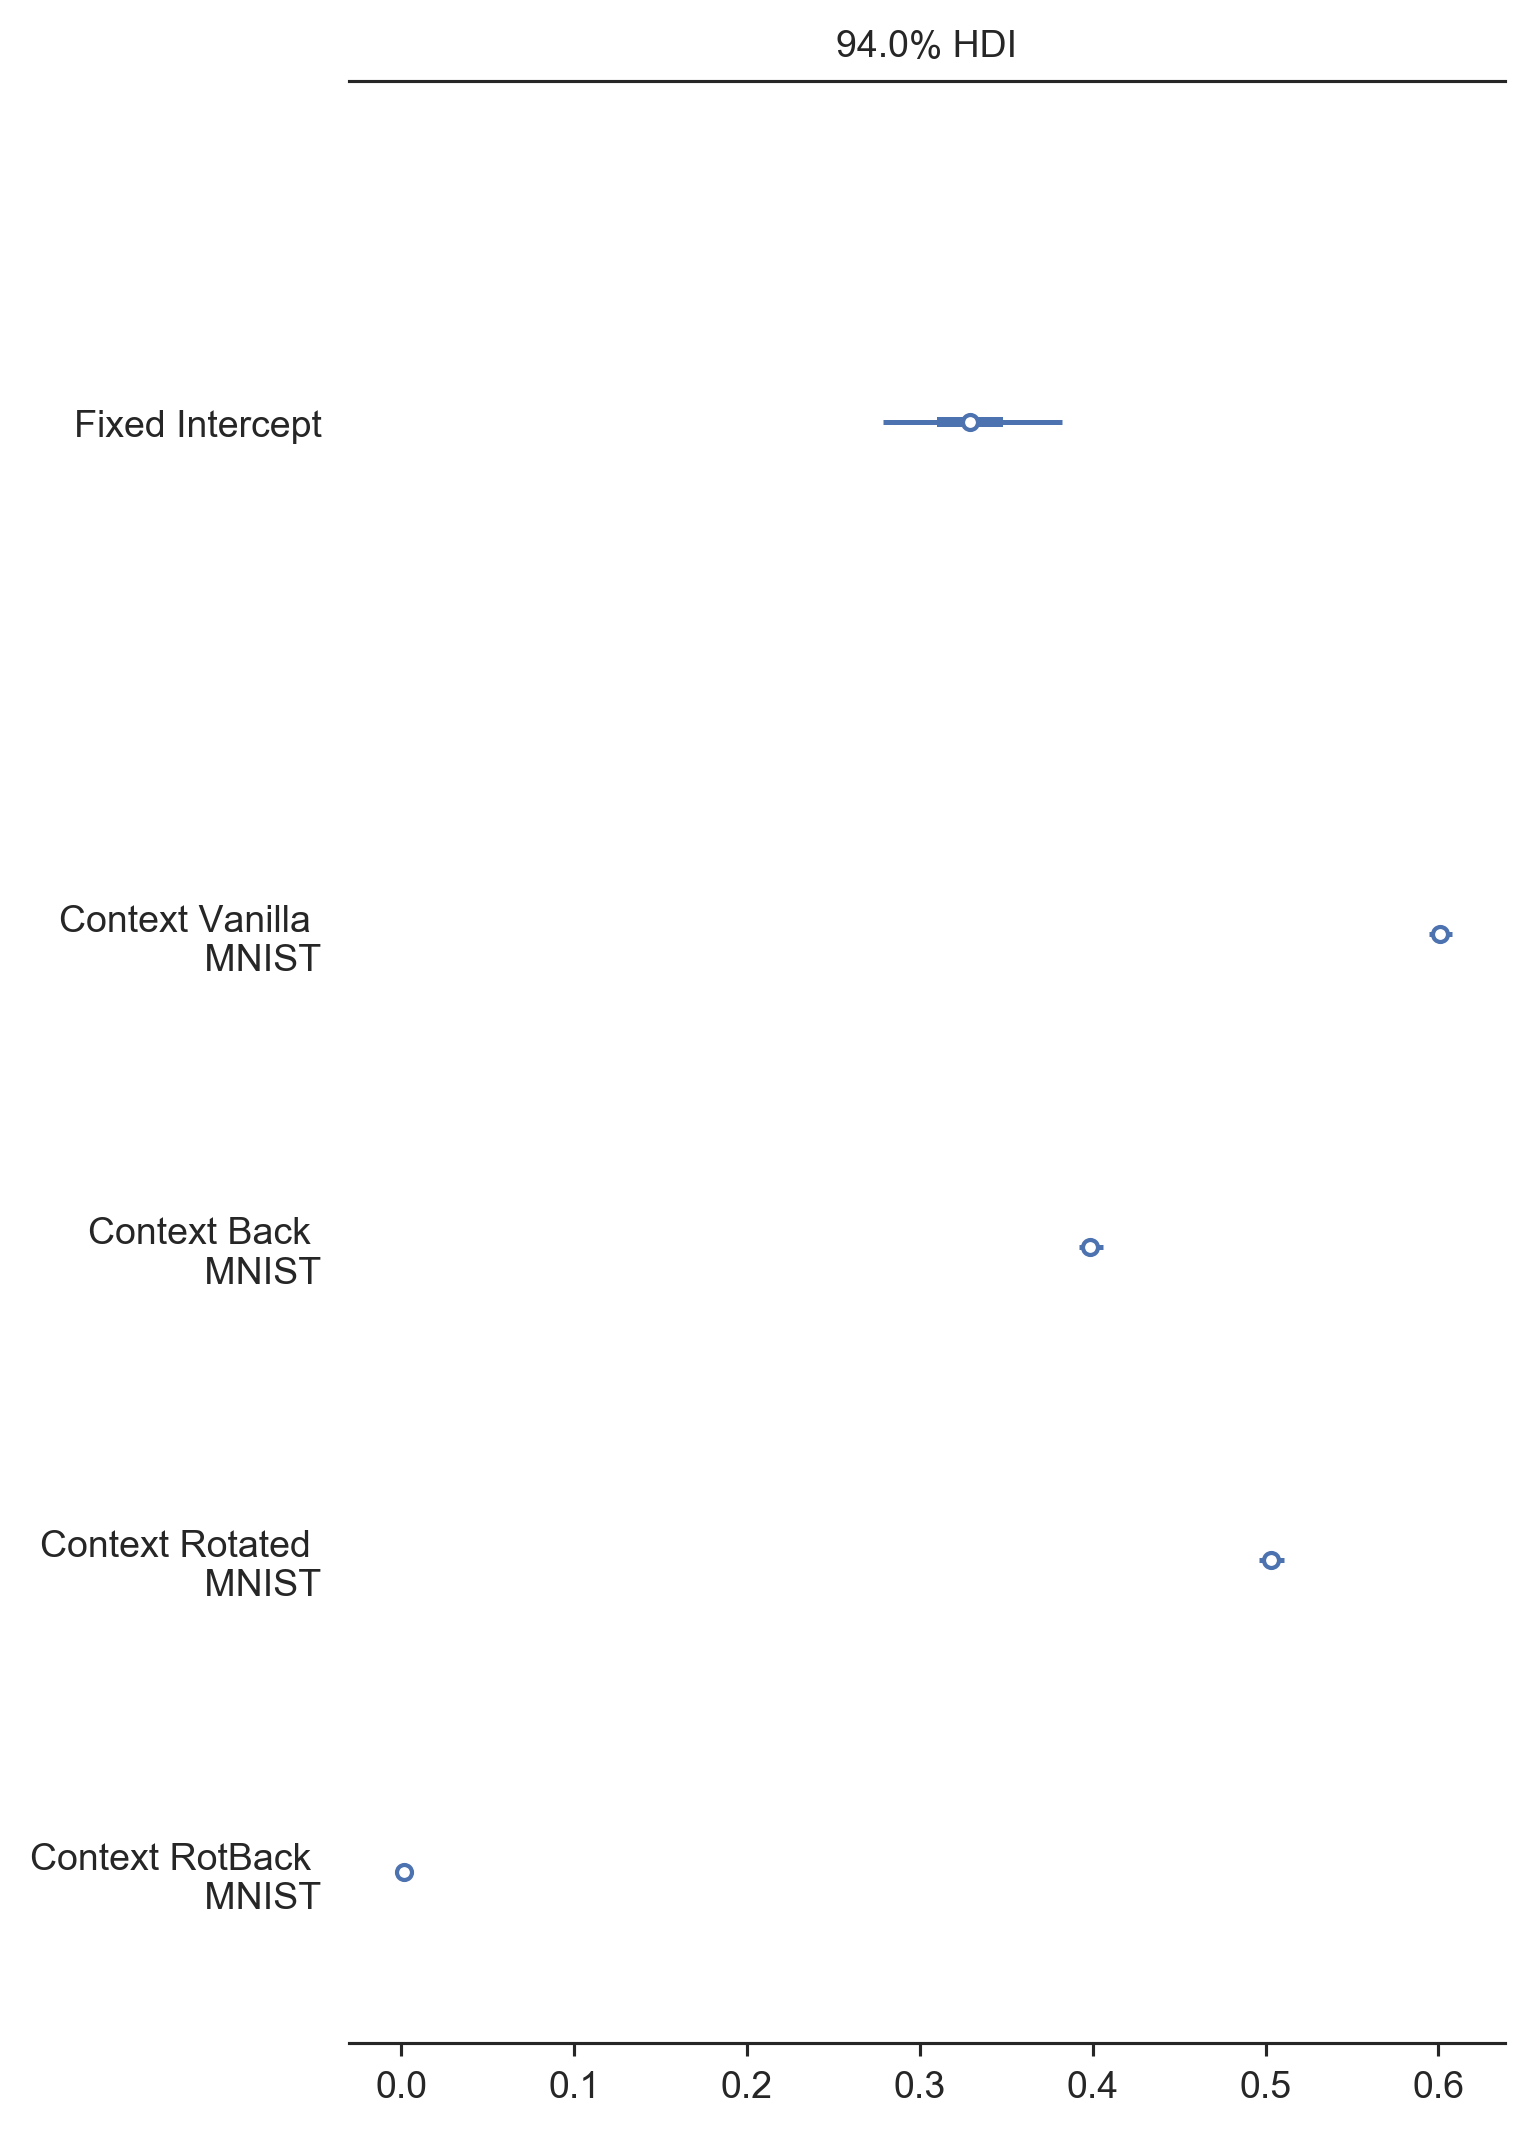

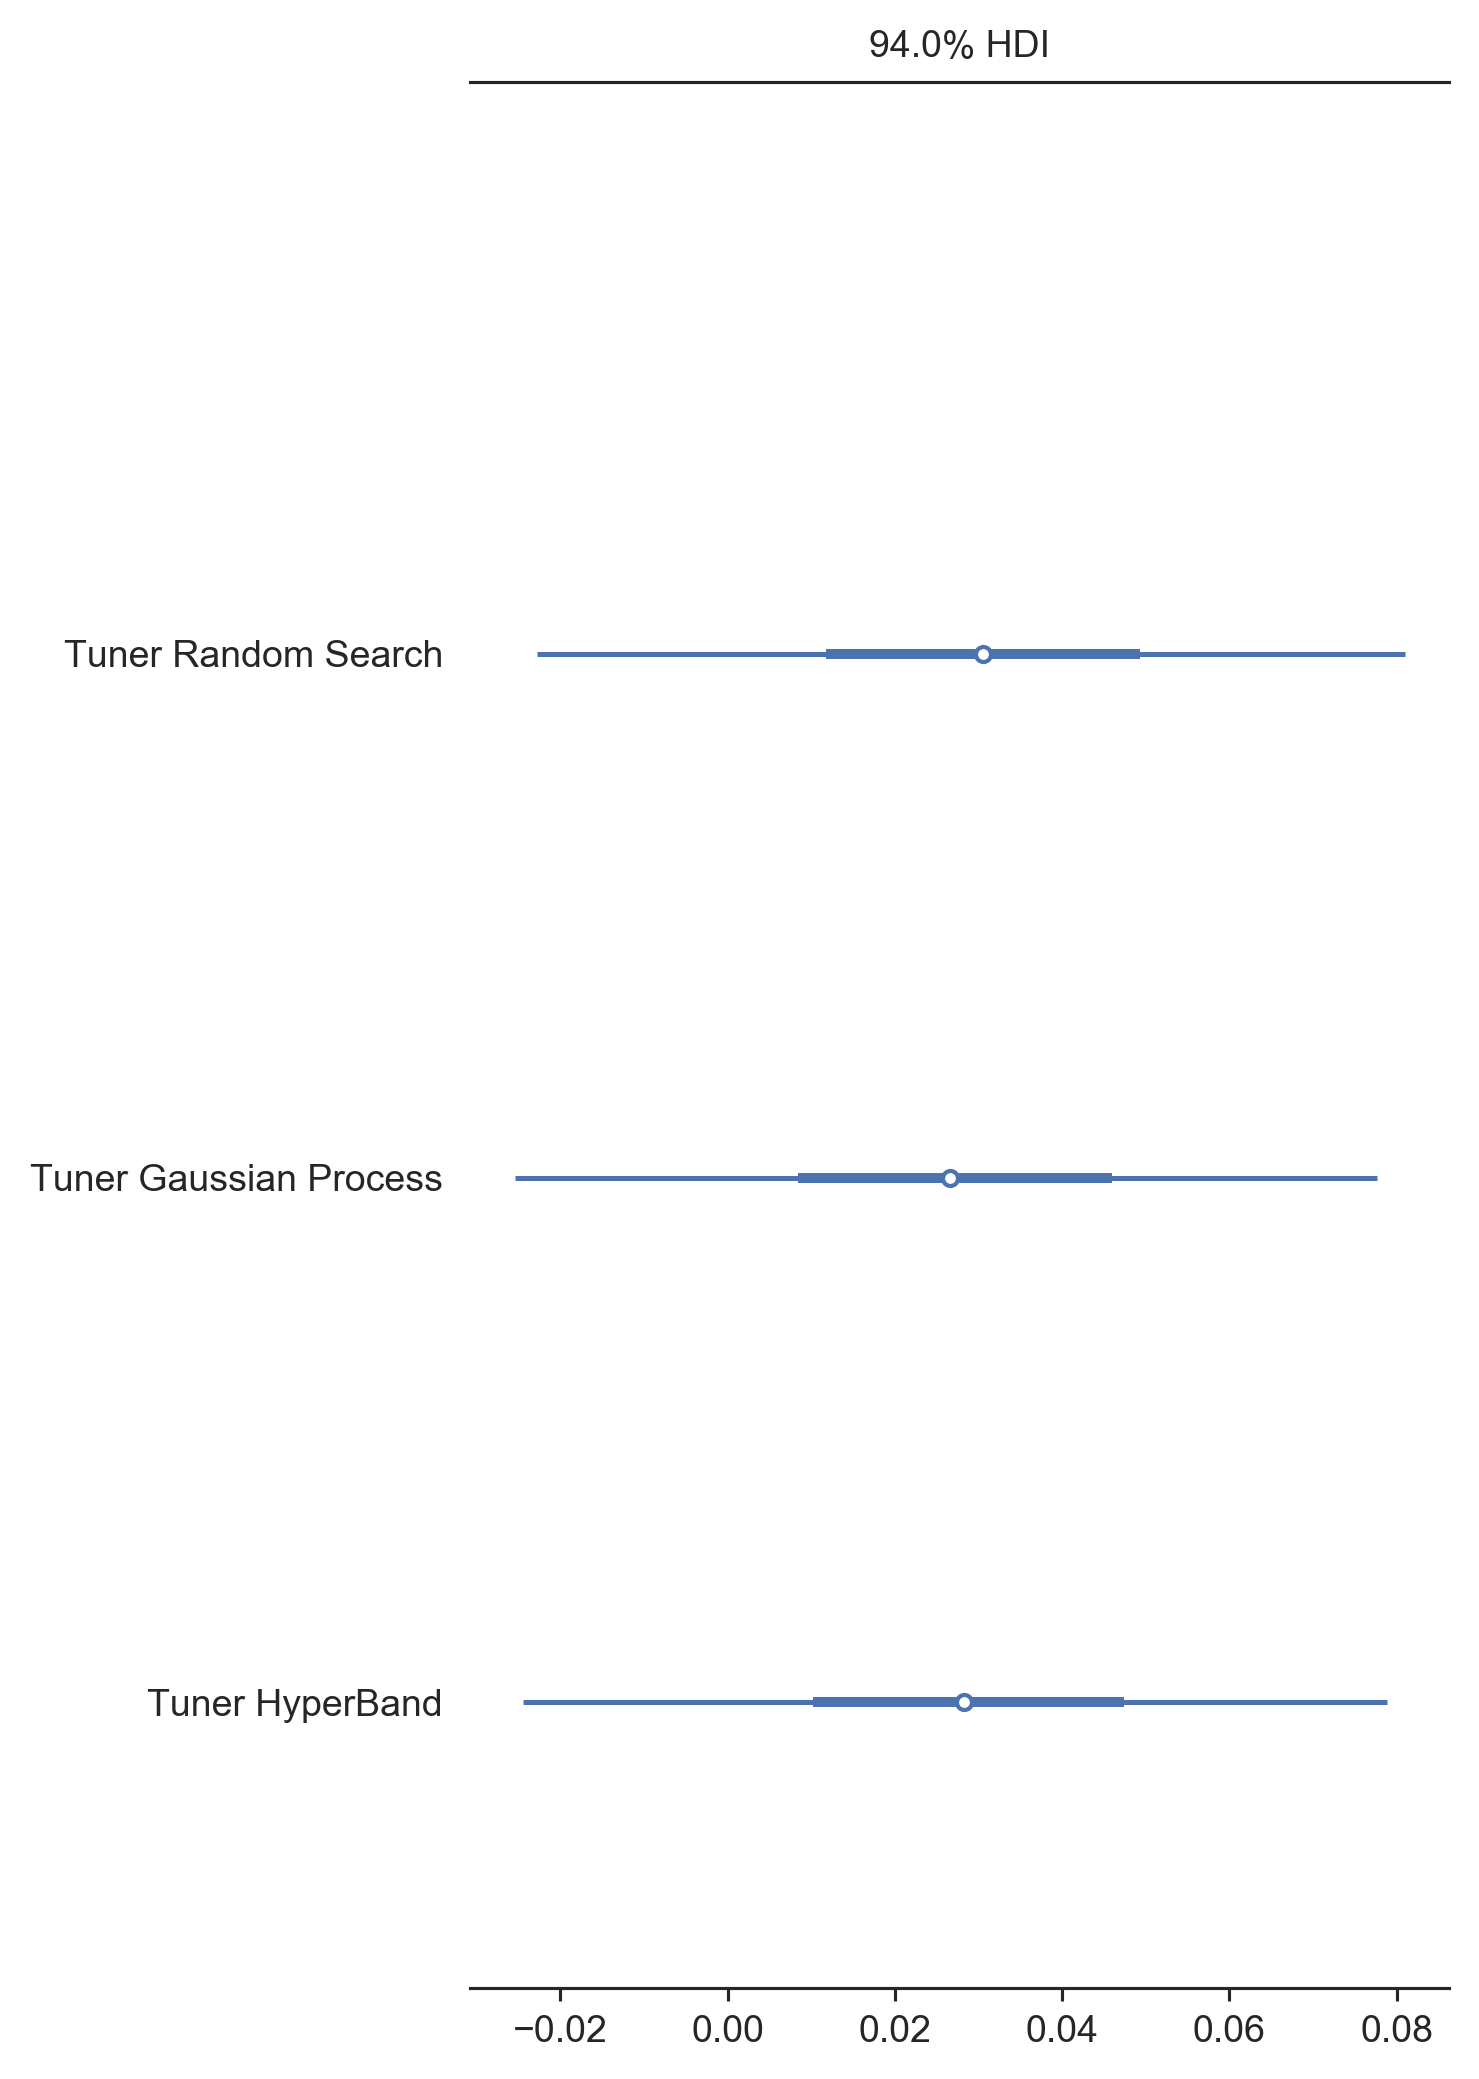

In [20]:
analyzer = GLMMPerformance(
    df=melted, 
    tuners_column='Tuner', 
    contexts_column='Source', 
    targets_column='metric'
)
traces = analyzer.analyze(
    targets=['Accuracy'],
    draws=1000,
    tune=1000,
    target_accept=0.9,
    figsize=(5, 7)
)